## Contents

* Loading Data
* RNN
* CRF
* Results Comparison

## I. Load Data

In [1]:
import pickle

In [2]:
path = "/Users/jacobsw/Desktop/WORK/OJO/NER_PRESENTATION/DATA/atis.pkl"

In [3]:
def load_atis(path):
    
    with open(path, 'rb') as f:
        train, valid, test, dicts = pickle.load(f)
    
    train = (train[0],train[2]) # 0: encoded words; 1: encoded labels.
    valid = (valid[0],valid[2])
    test = (test[0],test[2])

    return {'train':train, 'valid':valid, 'test':test, 'dicts':dicts}

In [4]:
data = load_atis(path)

In [5]:
TRAIN_SIZES = range(10,201,10) + range(300,1001,100) + [2000,3000,3983]

In [6]:
print TRAIN_SIZES

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 3983]


## II. RNN

In [7]:
import numpy as np

In [8]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Activation, TimeDistributed
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from keras.regularizers import l1, l2

Using Theano backend.


### A. Unidirectional RNN

In [10]:
class RNN:
    
    def __init__(self, data, mode='simple_rnn'):
        '''
        # data: a dictionary which contains ...
            {'train':train, 'valid':valid, 'test':test, 'dicts':dicts}
            each value in the dictionary is a 2-tuple ...
            (encoded_sentences, encoded_labels)
            dicts includes ...
            'words2idx', 'labels2idx'
        # mode: 'simple_rnn', 'lstm', 'gru'.
        '''
        if mode not in ['simple_rnn','lstm','gru']:
            print "MODE ERROR: only 'simple_rnn','lstm','gru'. \n"
            return
        self.mode = mode
        
        transform = {'x': lambda x: np.asarray([x]), 
                     'y': lambda y: to_categorical(np.asarray(y)[:,np.newaxis],
                                                   len(data['dicts']['labels2idx']))[np.newaxis,:,:]}
            # len(data['dicts']['labels2idx']): number of labels.
        try:
            data_transformed = [ (map(transform['x'],x), map(transform['y'],y)) 
                                 for x,y in [data['train'], data['valid'], data['test']] ]
            self.X_train, self.Y_train = data_transformed[0]
            self.X_valid, self.Y_valid = data_transformed[1]
            self.X_test, self.Y_test = data_transformed[2]
            self.dicts = data['dicts']
        except:
            print "DATA FORMAT ERROR: \n", \
                  "data = {'train':train, 'valid':valid, 'test':test, 'dicts':dicts} \n", \
                  "value = (encoded_sentences, encoded_labels) \n"
    
    def __shuffle(self, X, Y, seed):
        '''
        # X, Y: data and corresponding labels.
        # seed: ensure the same after-shuffle order for X and Y.
        '''
        random.seed(seed)
        random.shuffle(X)
        random.seed(seed)
        random.shuffle(Y)
    
    def __get_mean_evaluation(self, X, Y, model):
        '''
        # X, Y: data and corresponding labels.
        # return: average loss and accuracy on X and Y
        '''
        evaluation_size = len(X)
        losses, accuracies = [], []
        for i in xrange(evaluation_size):
            loss,accuracy = model.evaluate(X[i],Y[i],verbose=0)
            losses.append(loss)
            accuracies.append(accuracy)
        return (np.mean(losses),np.mean(accuracies))
    
    def train(self, validation=False, validation_freq=1000,
                    lr=.1, nhidden=100, emb_dim=100, nepochs=20,
                    regularize=False, reg_method='l2',lmd=.1,
                    TRAIN_SIZE=0,
                    report_architecture=0):
        '''
        # validation, validation_freq: 
            if true, run validation at validation_freq epoch (1 by default).
        # verbose, verbose_freq: 
            0: only print out simple messages (e.g. '... building models').
            1: print out validation too.
            print training progress after training every verbose_freq sentences.
        # lr: learning rate.
        # nhidden: number of hidden neurons.
        # emb_dim: dimension of word embeddings.
        # nepochs: number of epochs.
        # regularize: regularize or not.
        # reg_method: Lasso or L2 regularization.
        # lmd: regularization hyperparam.
        # return: end training when max patience is reached.
        '''
        
        vocsize = len(self.dicts['words2idx'])
        nlabels = len(self.dicts['labels2idx'])
        nsents = TRAIN_SIZE
        self.dicts['idx2labels'] = {i:l for l,i in self.dicts['labels2idx'].iteritems()}
        self.dicts['idx2words'] = {i:w for w,i in self.dicts['words2idx'].iteritems()}
            
        if regularize:
            regularizer = l2(lmd) if reg_method=='l2' else l1(lmd)
        else:
            regularizer = None
        model_types = {'simple_rnn':SimpleRNN, 'lstm':LSTM, 'gru':GRU}
        model = Sequential()
        model.add(Embedding(input_dim=vocsize, output_dim=emb_dim, W_regularizer=regularizer))
        model.add(model_types[self.mode](output_dim=nhidden, activation='sigmoid', 
                       return_sequences=True, W_regularizer=regularizer))
        model.add(TimeDistributed(Dense(output_dim=nlabels)))
        model.add(Activation('softmax'))
        sgd = SGD(lr=lr, momentum=.0, decay=.0, nesterov=False)
        model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
        
        if report_architecture: 
            model.summary()
            return
        
        self.best_model = model
        
        patience = 3000
        patience_increase_ratio = 2
        improvement_threshold = .995
        best_iter = 0
        best_loss = np.inf
        best_accuracy = 0.
        done_looping = False # stop training when patience are broken.
        num_iter = 0
        for e in xrange(nepochs):
            if done_looping: break
            e += 1       
            assert TRAIN_SIZE != 0
            sample_idxs = random.sample(range(len(self.X_train)),TRAIN_SIZE)
            X_train_samples = [self.X_train[k] for k in sample_idxs]
            Y_train_samples = [self.Y_train[k] for k in sample_idxs]
            
            self.__shuffle(X_train_samples,Y_train_samples,seed=0)
            for i in xrange(nsents):
                num_iter += 1
                if X_train_samples[i].shape[1]==1: continue
                model.train_on_batch(X_train_samples[i],Y_train_samples[i])
        
                if validation and i%validation_freq==0:
                    sample_idxs = random.sample(range(len(self.X_valid)),100)
                    X_valid_samples = [self.X_valid[k] for k in sample_idxs]
                    Y_valid_samples = [self.Y_valid[k] for k in sample_idxs]
                    avg_loss, avg_accuracy = self.__get_mean_evaluation(X_valid_samples, 
                                                                        Y_valid_samples,
                                                                        model)
                    if avg_loss < best_loss*improvement_threshold and \
                       avg_accuracy > best_accuracy:
                        self.best_model = model
                        patience = max(patience, num_iter*patience_increase_ratio)
                        best_loss = avg_loss
                        best_accuracy = avg_accuracy
                        best_iter = num_iter                        
                    if patience <= num_iter:
                        done_looping = True
                        break

        mean_test_loss, mean_test_accuracy = self.__get_mean_evaluation(self.X_test,
                                                                        self.Y_test,
                                                                        self.best_model)
        
        return mean_test_accuracy


In [91]:
rnn = RNN(data)

In [12]:
# ARCHITECTURE, # PARAMS
rnn.train(report_architecture=1)

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
embedding_1 (Embedding)            (None, None, 100)   57200       embedding_input_1[0][0]          
____________________________________________________________________________________________________
simplernn_1 (SimpleRNN)            (None, None, 100)   20100       embedding_1[0][0]                
____________________________________________________________________________________________________
timedistributed_1 (TimeDistributed)(None, None, 127)   12827       simplernn_1[0][0]                
____________________________________________________________________________________________________
activation_1 (Activation)          (None, None, 127)   0           timedistributed_1[0][0]          
Total params: 90127
_______________________________________________________________________

In [92]:
%%time
rnn_accuracies = []
for size in TRAIN_SIZES:
    accuracy = rnn.train(TRAIN_SIZE=size)
    rnn_accuracies.append(accuracy)
    print "Size = %d | Accuracy = %.6f%%" % (size, accuracy*100)

Size = 10 | Accuracy = 60.926534%
Size = 20 | Accuracy = 60.926534%
Size = 30 | Accuracy = 62.528492%
Size = 40 | Accuracy = 70.138727%
Size = 50 | Accuracy = 68.223698%
Size = 60 | Accuracy = 68.597620%
Size = 70 | Accuracy = 70.184837%
Size = 80 | Accuracy = 69.888206%
Size = 90 | Accuracy = 73.033823%
Size = 100 | Accuracy = 76.805398%
Size = 110 | Accuracy = 78.052609%
Size = 120 | Accuracy = 73.764833%
Size = 130 | Accuracy = 77.988917%
Size = 140 | Accuracy = 79.011015%
Size = 150 | Accuracy = 79.122164%
Size = 160 | Accuracy = 79.318072%
Size = 170 | Accuracy = 76.887408%
Size = 180 | Accuracy = 79.315096%
Size = 190 | Accuracy = 79.359675%
Size = 200 | Accuracy = 81.037570%
Size = 300 | Accuracy = 82.794055%
Size = 400 | Accuracy = 85.562967%
Size = 500 | Accuracy = 87.164525%
Size = 600 | Accuracy = 89.697979%
Size = 700 | Accuracy = 90.153902%
Size = 800 | Accuracy = 90.995276%
Size = 900 | Accuracy = 90.801913%
Size = 1000 | Accuracy = 92.302970%
Size = 2000 | Accuracy = 94.

### B. Bidirectional LSTM

In [47]:
from keras.layers import Merge

In [86]:
class RNNBiDirectional:
    
    def __init__(self, data):
        
        transform = {'x': lambda x: np.asarray([x]), 
                     'y': lambda y: to_categorical(np.asarray(y)[:,np.newaxis],
                                                   len(data['dicts']['labels2idx']))[np.newaxis,:,:]}
            # len(data['dicts']['labels2idx']): number of labels.
        try:
            data_transformed = [ (map(transform['x'],x), map(transform['y'],y)) 
                                 for x,y in [data['train'], data['valid'], data['test']] ]
            self.X_train, self.Y_train = data_transformed[0]
            self.X_valid, self.Y_valid = data_transformed[1]
            self.X_test, self.Y_test = data_transformed[2]
            self.dicts = data['dicts']
        except:
            print "DATA FORMAT ERROR: \n", \
                  "data = {'train':train, 'valid':valid, 'test':test, 'dicts':dicts} \n", \
                  "value = (encoded_sentences, encoded_labels) \n"
    
    def __shuffle(self, X, Y, seed):
        random.seed(seed)
        random.shuffle(X)
        random.seed(seed)
        random.shuffle(Y)
    
    def __get_mean_evaluation(self, X, Y, model):
        evaluation_size = len(X)
        losses, accuracies = [], []
        for i in xrange(evaluation_size):
            loss,accuracy = model.evaluate([X[i],X[i]],Y[i],verbose=0)
            losses.append(loss)
            accuracies.append(accuracy)
        return (np.mean(losses),np.mean(accuracies))
    
    def train(self, validation=True, validation_freq=1000,
                    lr=.1, nhidden=100, emb_dim=100, nepochs=20,
                    regularize=False, reg_method='l2',lmd=.1,
                    TRAIN_SIZE=0,
                    report_architecture=0,
                    verbose=1):
        
        vocsize = len(self.dicts['words2idx'])
        nlabels = len(self.dicts['labels2idx'])
        nsents = TRAIN_SIZE
        self.dicts['idx2labels'] = {i:l for l,i in self.dicts['labels2idx'].iteritems()}
        self.dicts['idx2words'] = {i:w for w,i in self.dicts['words2idx'].iteritems()}
            
        if regularize:
            regularizer = l2(lmd) if reg_method=='l2' else l1(lmd)
        else:
            regularizer = None
        left = Sequential()
        left.add(Embedding(input_dim=vocsize, output_dim=emb_dim, W_regularizer=regularizer))
        left.add(LSTM(output_dim=nhidden, init='uniform', inner_init='uniform',
                       forget_bias_init='one', return_sequences=True, activation='tanh', 
                       W_regularizer=regularizer))   
        right = Sequential()
        right.add(Embedding(input_dim=vocsize, output_dim=emb_dim, W_regularizer=regularizer))
        right.add(LSTM(output_dim=nhidden, init='uniform', inner_init='uniform',
                       forget_bias_init='one', return_sequences=True, activation='tanh', 
                       W_regularizer=regularizer, go_backwards=True)) 
        model = Sequential()
        model.add(Merge([left,right], mode='sum'))
        
        model.add(TimeDistributed(Dense(output_dim=nlabels)))
        model.add(Activation('softmax'))
        sgd = SGD(lr=lr, momentum=.0, decay=.0, nesterov=False)
        model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
        
        if report_architecture: 
            model.summary()
            return
        
        self.best_model = model
        
        patience = 3000
        patience_increase_ratio = 2
        improvement_threshold = .995
        best_iter = 0
        best_loss = np.inf
        best_accuracy = 0.
        done_looping = False # stop training when patience are broken.
        num_iter = 0
        for e in xrange(nepochs):
            if done_looping: break
            e += 1       
            if verbose: print "... Epoch: %d" % e
            assert TRAIN_SIZE != 0
            sample_idxs = random.sample(range(len(self.X_train)),TRAIN_SIZE)
            X_train_samples = [self.X_train[k] for k in sample_idxs]
            Y_train_samples = [self.Y_train[k] for k in sample_idxs]
            
            self.__shuffle(X_train_samples,Y_train_samples,seed=0)
            for i in xrange(nsents):
                num_iter += 1
                if verbose and i!=0 and i%validation_freq==0: print "    ... trained %d sentences" % i
                if X_train_samples[i].shape[1]==1: continue
                model.train_on_batch([X_train_samples[i],X_train_samples[i]],Y_train_samples[i])
        
                if validation and i%validation_freq==0:
                    sample_idxs = random.sample(range(len(self.X_valid)),100)
                    X_valid_samples = [self.X_valid[k] for k in sample_idxs]
                    Y_valid_samples = [self.Y_valid[k] for k in sample_idxs]
                    avg_loss, avg_accuracy = self.__get_mean_evaluation(X_valid_samples, 
                                                                        Y_valid_samples,
                                                                        model)
                    print "Validation: Loss = %.6f | Accuracy = %.6f" % (avg_loss, avg_accuracy)
                    if avg_loss < best_loss*improvement_threshold and \
                       avg_accuracy > best_accuracy:
                        self.best_model = model
                        patience = max(patience, num_iter*patience_increase_ratio)
                        best_loss = avg_loss
                        best_accuracy = avg_accuracy
                        best_iter = num_iter  
                    if patience <= num_iter:
                        done_looping = True
                        break

        mean_test_loss, mean_test_accuracy = self.__get_mean_evaluation(self.X_test,
                                                                        self.Y_test,
                                                                        self.best_model)
        if verbose:
            print "Training Complete (at iteration %d)!" % num_iter
            print "Test on Best Model: Loss = %.6f | Accuracy = %.6f" % (mean_test_loss, mean_test_accuracy)
        
        return mean_test_accuracy


In [87]:
bilstm = RNNBiDirectional(data)

In [57]:
# ARCHITECTURE, # PARAMS
bilstm.train(report_architecture=1)

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
embedding_6 (Embedding)            (None, None, 100)   57200                                        
____________________________________________________________________________________________________
lstm_2 (LSTM)                      (None, None, 100)   80400                                        
____________________________________________________________________________________________________
embedding_7 (Embedding)            (None, None, 100)   57200                                        
____________________________________________________________________________________________________
lstm_3 (LSTM)                      (None, None, 100)   80400                                        
___________________________________________________________________________________________

In [80]:
%%time
bilstm.train(TRAIN_SIZE=3983)

... Epoch: 1


INFO (theano.gof.compilelock): Refreshing lock /Users/jacobsw/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-2.7.11-64/lock_dir/lock


Validation: Loss = 4.826993 | Accuracy = 0.074775
    ... trained 1000 sentences
Validation: Loss = 1.535742 | Accuracy = 0.671669
    ... trained 2000 sentences
Validation: Loss = 0.848941 | Accuracy = 0.822559
    ... trained 3000 sentences
Validation: Loss = 0.769305 | Accuracy = 0.820691
... Epoch: 2
Validation: Loss = 0.771408 | Accuracy = 0.822868
    ... trained 1000 sentences
Validation: Loss = 0.658268 | Accuracy = 0.857653
    ... trained 2000 sentences
Validation: Loss = 0.467708 | Accuracy = 0.892870
    ... trained 3000 sentences
Validation: Loss = 0.460466 | Accuracy = 0.888917
... Epoch: 3
Validation: Loss = 0.488561 | Accuracy = 0.899005
    ... trained 1000 sentences
Validation: Loss = 0.399148 | Accuracy = 0.911707
    ... trained 2000 sentences
Validation: Loss = 0.328117 | Accuracy = 0.928871
    ... trained 3000 sentences
Validation: Loss = 0.304856 | Accuracy = 0.933451
... Epoch: 4
Validation: Loss = 0.364412 | Accuracy = 0.923727
    ... trained 1000 sentences
V

0.96729254091840577

In [88]:
%%time
bilstm_accuracies = []
for size in TRAIN_SIZES:
    accuracy = bilstm.train(validation=False, TRAIN_SIZE=size, verbose=0)
    bilstm_accuracies.append(accuracy)
    print "Size = %d | Accuracy = %.6f%%" % (size, accuracy*100)

Size = 10 | Accuracy = 60.571795%
Size = 20 | Accuracy = 60.926534%
Size = 30 | Accuracy = 60.926534%
Size = 40 | Accuracy = 60.935148%
Size = 50 | Accuracy = 62.356547%
Size = 60 | Accuracy = 67.651188%
Size = 70 | Accuracy = 67.580179%
Size = 80 | Accuracy = 70.843461%
Size = 90 | Accuracy = 74.312489%
Size = 100 | Accuracy = 74.904931%
Size = 110 | Accuracy = 76.078032%
Size = 120 | Accuracy = 76.674197%
Size = 130 | Accuracy = 78.935041%
Size = 140 | Accuracy = 80.142289%
Size = 150 | Accuracy = 79.581505%
Size = 160 | Accuracy = 79.664173%
Size = 170 | Accuracy = 79.825608%
Size = 180 | Accuracy = 79.467649%
Size = 190 | Accuracy = 80.422014%
Size = 200 | Accuracy = 80.360226%
Size = 300 | Accuracy = 84.187828%
Size = 400 | Accuracy = 87.177190%
Size = 500 | Accuracy = 89.384273%
Size = 600 | Accuracy = 90.326245%
Size = 700 | Accuracy = 91.845310%
Size = 800 | Accuracy = 92.487245%
Size = 900 | Accuracy = 93.017744%
Size = 1000 | Accuracy = 93.756565%
Size = 2000 | Accuracy = 95.

## III. CRF

In [93]:
import spacy
from spacy.en import English
from pyparsing import StringEnd, oneOf, FollowedBy, Optional, ZeroOrMore, SkipTo
from itertools import chain
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import sklearn
import pycrfsuite
import os, cPickle, time, random
from sklearn.metrics import accuracy_score
from itertools import chain

### A. Extract Info Using Spacy

In [94]:
parser = English()

In [95]:
train, valid, test, dicts = data['train'], data['valid'], data['test'], data['dicts']
i2w = {i:w for w,i in dicts['words2idx'].iteritems()}
i2l = {i:l for l,i in dicts['labels2idx'].iteritems()}

In [96]:
X_train = [map(i2w.get, encoded_sent) for encoded_sent in train[0]]
X_test = [map(i2w.get, encoded_sent) for encoded_sent in test[0]]
Y_train = [map(i2l.get, encoded_labels) for encoded_labels in train[1]]
Y_test = [map(i2l.get, encoded_sent) for encoded_sent in test[1]]

In [97]:
def extract_info(sent): 
    
    if type(sent)==list: sent = ' '.join(sent)
    parsed = parser(unicode(sent))# if type(sent)==str else parser(unicode(sent))
    pos = [token.pos_ for token in parsed]
    ner = ['none' if token.ent_type_=='' else token.ent_type_ for token in parsed]
    dep_rel = [token.dep_ for token in parsed]
    dep_head = [token.head.orth_ for token in parsed]
    
    return (sent.split(), pos, ner, dep_rel, dep_head)


In [98]:
X_train_augmented = [extract_info(sent) for sent in X_train]
X_test_augmented = [extract_info(sent) for sent in X_test]

### B. Featurization

In [99]:
prefix = ['anti','de','dis','en','em','fore','in','im','il','ir',
          'inter','mid','mis','non','over','pre','re','semi','sub',
          'super','trans','un','under']
suffix = ['able','ible','al','ial','ed','en','er','est','ful','ic',
          'ing','ion','tion','ation','ition','ity','ty','ive','ative',
          'itive','less','ly','ment','ness','ous','eous','ious','s',
          'es','y','ism']

In [100]:
class Featurize:
    
    def __init__(self, prefix=[], suffix=[]): # lists of pfx/sfx.
        self.prefix = prefix
        self.suffix = suffix
        end_of_string = StringEnd()
        pfx_pyp_regex = oneOf(' '.join(prefix))
        sfx_pyp_regex = oneOf(' '.join(suffix)) + FollowedBy(end_of_string)
        self.template = (ZeroOrMore(pfx_pyp_regex)('prefix') +
                         SkipTo(sfx_pyp_regex | end_of_string)('root') + 
                         Optional(sfx_pyp_regex)('suffix'))              
        self.afx = lambda word: self.template.parseString(word)
        self.feat_set = {'pfx': lambda w_idx,datum: self.afx(datum[0][w_idx]).prefix[0] \
                                     if self.afx(datum[0][w_idx]).prefix!='' else 'no_pfx',
                         'sfx': lambda w_idx,datum: self.afx(datum[0][w_idx]).suffix[0] \
                                     if self.afx(datum[0][w_idx]).suffix!='' else 'no_sfx',
                         'root': lambda w_idx,datum: self.afx(datum[0][w_idx]).root,
                         'word': lambda w_idx,datum: datum[0][w_idx],
                         'pos': lambda w_idx,datum: datum[1][w_idx],
                         'ner': lambda w_idx,datum: datum[2][w_idx],
                         'dep_rel': lambda w_idx,datum: datum[3][w_idx],
                         'dep_head': lambda w_idx,datum: datum[4][w_idx]} 
            # datum: (words, pos, ner, dep_rel, dep_head)
        
    def word_featurize(self, datum, i, 
                       FEATURES=['pfx','sfx','root','word','pos','ner','dep_rel','dep_head']): 
        # datum: (sent, pos, ner, dep_rel, dep_head).
        # i: index of the token processed. 
        features = []
        for feat in FEATURES:
            features.append(feat+'='+str(self.feat_set[feat](i,datum)))
        if i > 0:
            for feat in FEATURES:
                features.append('-1'+feat+'='+str(self.feat_set[feat](i-1,datum)))
                if i > 1:
                    features.append('-2'+feat+'='+str(self.feat_set[feat](i-2,datum)))
        else: features.append('BOS')
        if i < len(datum[0])-1:
            for feat in FEATURES:
                features.append('+1'+feat+'='+str(str(self.feat_set[feat](i+1,datum))))
                if i < len(datum[0])-2:
                    features.append('+2'+feat+'='+str(str(self.feat_set[feat](i+2,datum))))
        else: features.append('EOS')    
        return features
        
    def sent_featurize(self, datum, FEATURES=['pfx','sfx','root','word','pos','ner','dep_rel','dep_head']):
        # datum: (sent, pos, ner, dep_rel, dep_head).   
        return [self.word_featurize(datum, i, FEATURES) for i in xrange(len(datum[0]))] 

In [101]:
train = [(x_augmented,y) for x_augmented,y in zip(X_train_augmented,Y_train)]
test = [(x_augmented,y) for x_augmented,y in zip(X_test_augmented,Y_test)]

In [102]:
class CRF:
    
    def __init__(self, train, test,
                 featurizer=Featurize(prefix, suffix),
                 FEATURES=['pfx','sfx','root','word','pos','ner','dep_rel','dep_head']):
        self.FEATURES = FEATURES
        self.X_train = [featurizer.sent_featurize(datum[0],FEATURES) for datum in train]
        self.Y_train = [datum[1] for datum in train]
        self.X_test = [featurizer.sent_featurize(datum[0],FEATURES) for datum in test]
        self.Y_test = [datum[1] for datum in test]
    
    def train(self, TRAIN_SIZE=0, config={'c1': 1.0, 
                                          'c2': 1e-3, 
                                          'max_iterations': 100,
                                          'feature.possible_transitions':True},
                                  verbose=0):
        crf = pycrfsuite.Trainer(verbose=verbose)    
        assert TRAIN_SIZE != 0
        sample_idxs = random.sample(range(len(self.X_train)), TRAIN_SIZE)
        X = [self.X_train[k] for k in sample_idxs]
        Y = [self.Y_train[k] for k in sample_idxs]            
        for x,y in zip(X,Y):
            crf.append(x,y)
        crf.set_params(config)
        tagger_name=time.ctime()+'crf.crfsuite' # avoid repetition
        crf.train(tagger_name)
        self.tagger = pycrfsuite.Tagger()
        self.tagger.open(tagger_name)
        
        y_true = self.Y_test
        y_pred = [self.tagger.tag(sent) for sent in self.X_test]
        y_true_merged = list(chain.from_iterable(y_true))
        y_pred_merged = list(chain.from_iterable(y_pred)) 
        accuracy = accuracy_score(y_true_merged,y_pred_merged)
        
        return accuracy
        

In [103]:
%%time
crf = CRF(train, test)

CPU times: user 2min 58s, sys: 841 ms, total: 2min 59s
Wall time: 2min 59s


In [104]:
# ARCHITECTURE, # PARAMS
crf.train(TRAIN_SIZE=3983, config= {'c1':1.,'c2':1e-3,'max_iterations':100,'feature.possible_transitions':True}, 
          verbose=1)
# active features at beginning: 44785
# active features at end: 4584

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 57692
Seconds required: 0.497

L-BFGS optimization
c1: 1.000000
c2: 0.001000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

***** Iteration #1 *****
Loss: 122711.917795
Feature norm: 1.000000
Error norm: 71498.967048
Active features: 44785
Line search trials: 1
Line search step: 0.000010
Seconds required for this iteration: 3.788

***** Iteration #2 *****
Loss: 105076.429101
Feature norm: 2.308370
Error norm: 51738.228841
Active features: 43625
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 3.655

***** Iteration #3 *****
Loss: 88688.003861
Feature norm: 2.122074
Error norm: 37622.714121
Active features: 44442
Line search trials: 1
Line search step: 1.000000
Seconds required f

0.95912154816264406

In [105]:
%%time
crf_accuracies = []
for size in TRAIN_SIZES:
    accuracy = crf.train(TRAIN_SIZE=size)
    crf_accuracies.append(accuracy)
    print "Size = %d | Accuracy = %.6f%%" % (size, accuracy*100)

Size = 10 | Accuracy = 71.211133%
Size = 20 | Accuracy = 78.103936%
Size = 30 | Accuracy = 77.679930%
Size = 40 | Accuracy = 79.930420%
Size = 50 | Accuracy = 83.007175%
Size = 60 | Accuracy = 80.843662%
Size = 70 | Accuracy = 80.158730%
Size = 80 | Accuracy = 81.963470%
Size = 90 | Accuracy = 85.920852%
Size = 100 | Accuracy = 85.866493%
Size = 110 | Accuracy = 83.735595%
Size = 120 | Accuracy = 85.235921%
Size = 130 | Accuracy = 86.584040%
Size = 140 | Accuracy = 87.127636%
Size = 150 | Accuracy = 87.008045%
Size = 160 | Accuracy = 87.051533%
Size = 170 | Accuracy = 86.323114%
Size = 180 | Accuracy = 86.801479%
Size = 190 | Accuracy = 86.964558%
Size = 200 | Accuracy = 87.845184%
Size = 300 | Accuracy = 88.497499%
Size = 400 | Accuracy = 89.802131%
Size = 500 | Accuracy = 91.791694%
Size = 600 | Accuracy = 92.161339%
Size = 700 | Accuracy = 92.857143%
Size = 800 | Accuracy = 93.455099%
Size = 900 | Accuracy = 92.965862%
Size = 1000 | Accuracy = 93.596434%
Size = 2000 | Accuracy = 95.

## Result Comparison

In [106]:
import matplotlib.pyplot as plt
%matplotlib inline

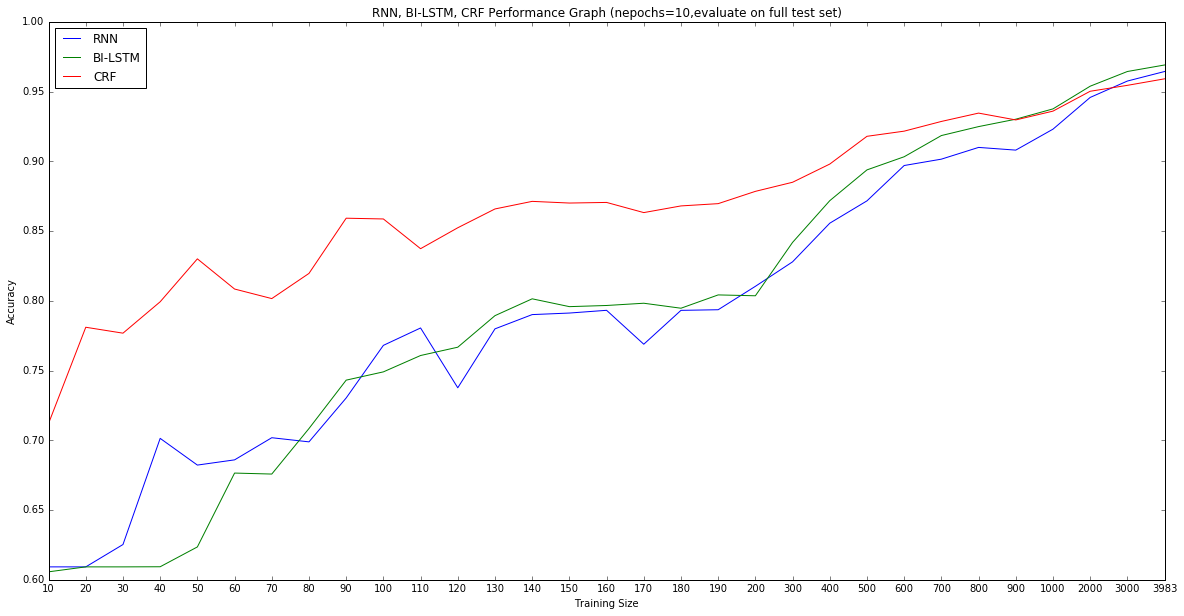

In [107]:
plt.figure(figsize=(20,10))
plt.plot(rnn_accuracies)
plt.plot(bilstm_accuracies)
plt.plot(crf_accuracies)
plt.title("RNN, BI-LSTM, CRF Performance Graph (nepochs=10,evaluate on full test set)")
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(['RNN', 'BI-LSTM', 'CRF'],loc=2)
plt.xticks(np.arange(len(TRAIN_SIZES)),TRAIN_SIZES)
plt.show()

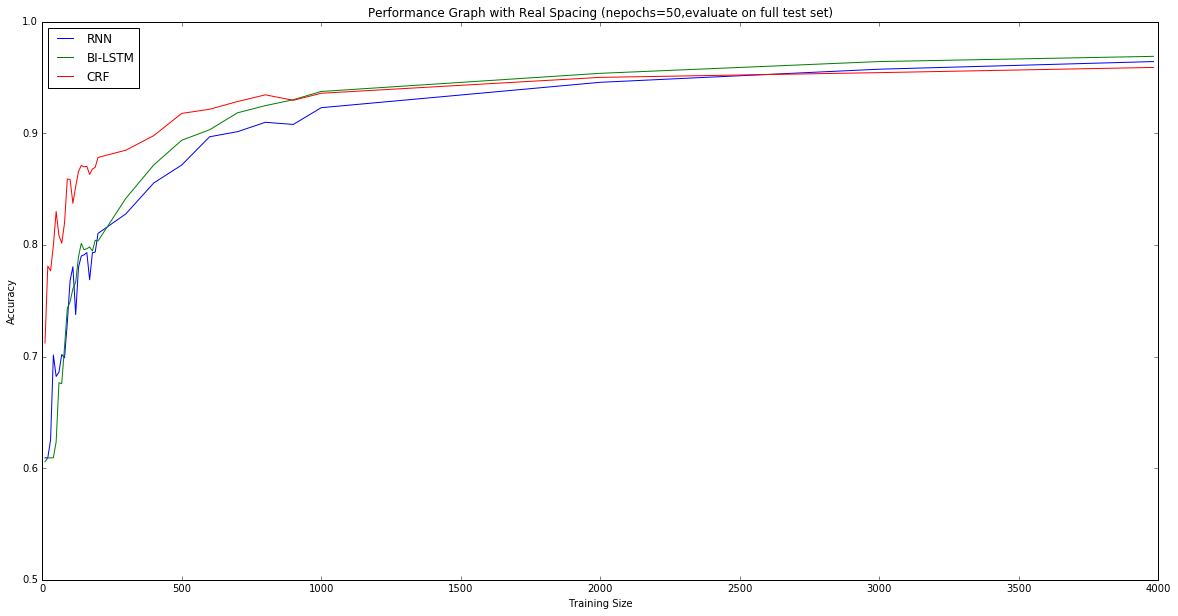

In [109]:
plt.figure(figsize=(20,10))
plt.plot(TRAIN_SIZES, rnn_accuracies)
plt.plot(TRAIN_SIZES, bilstm_accuracies)
plt.plot(TRAIN_SIZES, crf_accuracies)
plt.title("Performance Graph with Real Spacing (nepochs=50,evaluate on full test set)")
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.ylim(0.5,1)
plt.legend(['RNN','BI-LSTM','CRF'],loc=2)
plt.show()

In [110]:
crf.Y_train[0]

['O',
 'O',
 'O',
 'B-fromloc.city_name',
 'O',
 'B-depart_time.time_relative',
 'B-depart_time.time',
 'O',
 'O',
 'B-depart_time.period_of_day',
 'O',
 'O',
 'O',
 'B-toloc.city_name',
 'I-toloc.city_name']